In [ ]:
import numpy as np
import pandas as pd
import os
# from pandas_datareader import data
from datetime import timedelta, date, datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# MLP code

In [16]:
def apply_MLP(X_train,X_test,y_train,y_test):
  sc_X = StandardScaler()
  X_trainscaled=sc_X.fit_transform(X_train)
  X_testscaled=sc_X.transform(X_test)
  reg = MLPRegressor(hidden_layer_sizes=(5,15,5),activation="relu" ,random_state=1, max_iter=2000).fit(X_trainscaled, y_train)
  y_pred=reg.predict(X_testscaled)
  #print("The Score with ", (r2_score(y_test, y_pred)))
  y_pred = pd.DataFrame(y_pred)
  out = pd.concat([y_test.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)
  out = out.rename(columns={0:"Prediction"})
  #print("The Score with out ", (r2_score(out['Ground Truth'], out['Prediction'])))
  return out

# Load data and apply MLP

In [166]:
symlist = ['AAPL', 'ADI', 'AMT', 'AMZN', 'BABA', 'COUP', 'CRM', 'ERIC', 'GOOGL', 'MELI', 'MSFT', 'NVDA', 'OKTA', 'PANW', 'PYPL', 'QCOM', 'SHOP', 'SQ', 'TMUS']
# symbol=symlist[0]
# Append all stocks along the rows and redefine the index
# weekly_or_monthly = 'monthly'
data_type = 'yahoo' # reddit, twitter, yahoo
how_long_list = [7,40,90]
how_long_text = ['weekly', 'monthly', 'quarterly']
term_stock = ['weekly stock', 'monthly stock', 'quarterly stock']
term_sentiment = ['Weekly Sentiment', 'Monthly Sentiment', 'Quarterly Sentiment']
column_list = ['Short Term', 'Mid Term', 'Long Term']

twit_sentiment_list = ['weekly average', 'monthly average', 'long term average']
twit_stock_list = ['short-term stock', 'mid-term stock', 'long-term stock']

# how_long = "weekly": 7, "monthly":40, "Quarterly":90
df_r2_all=[]
for idx,how_long in enumerate(how_long_list):
  # weekly_or_monthly=how_long_text[idx]
  append_df=[] #list of dataframes
  append_X=[]
  append_Y=[]
  for symbol in symlist:
    dfy=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/yahoo_stock_ground_truth/{}_avg.csv'.format(symbol), index_col=0)
    dfy.interpolate(limit_direction='both',inplace=True)
    if data_type=='yahoo':
      df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/yahoo_all_data/{}.csv'.format(symbol), index_col=0)
      X = df[['Adj Close','Volume', 'Surprise_EPS',term_sentiment[idx]]]#'Total Sentiment','Avg Sentiment'
      Y = df[term_stock[idx]]
    elif data_type=='twitter':
      dft=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/twitter_avgData/{}_Twitavg.csv'.format(symbol), index_col=0)
      dft.drop(dft.index[-1],inplace=True)
      dft.interpolate(limit_direction='both',inplace=True)
      X = pd.concat([dfr[[twit_sentiment_list[idx]]], dfy[['Adj Close','Volume']]],axis=1)
      Y = dfy[twit_stock_list[idx]]
    elif data_type=='reddit':
      dfr=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sentiment_avg/{}_avg.csv'.format(symbol), index_col=0)
      dfr.drop(dfr.index[-1],inplace=True)
      dfr.interpolate(limit_direction='both',inplace=True)
      X = pd.concat([dfr[[twit_sentiment_list[idx]]], dfy[['Adj Close','Volume']]],axis=1)
      Y = dfy[twit_stock_list[idx]]
    # Y=prepare_data_Y_for_ML(df, how_long)
    append_Y.append(Y)
    # X=prepare_data_X_for_ML(df, how_long)
    #X.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
    append_X.append(X)
    #print(df.shape)
    #df=df.drop(['Date','Estimated_Revenue','Reported_Revenue','Estimated_EPS','Reported_EPS','Period Ending'],axis=1)
    # append_df.append(df)
  
  # df2=pd.concat(append_df)
  # df2.shape

  Xall=pd.concat(append_X)
  Yall=pd.concat(append_Y)
  Yall.rename('Ground Truth', inplace=True)
  # Train on all  data
  X_train,X_test,y_train,y_test = train_test_split(Xall,Yall,test_size=0.25,random_state=0)
  out=apply_MLP(X_train,X_test,y_train,y_test)
  r2score_all=r2_score(out['Ground Truth'], out['Prediction'])
  #print(out)
  print("The Score All ", (r2_score(out['Ground Truth'], out['Prediction'])))

  #Train individually 
  r2score_list = []
  for si,symbol in enumerate(symlist):
    df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/yahoo_prepared_df/{}.csv'.format(symbol), index_col=0)
    X=append_X[si]
    Y=append_Y[si]
    Y.rename('Ground Truth', inplace=True)
    # Y=prepare_data_Y_for_ML(df,  how_long)
    # X=prepare_data_X_for_ML(df,  how_long)
    #X.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
    #X=X.drop(['Adj Close'],axis=1)
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)
    out=apply_MLP(X_train,X_test,y_train,y_test)
    print("The Score Individual ", (r2_score(out['Ground Truth'], out['Prediction'])))
    r2score_list.append(r2_score(out['Ground Truth'], out['Prediction']))
  df_r2 = pd.DataFrame({'r2':r2score_list}, index=symlist)
  df_r2=df_r2.append(pd.DataFrame({'r2':r2score_all}, index=['All Stocks']))
  df_r2.rename(columns={'r2':column_list[idx]}, inplace=True)
  df_r2_all.append(df_r2)


The Score All  0.036285621922736544


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  -0.03929159638682678


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.35435356150244113


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.4129481087235338


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.06734859633462353


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.40091917406828825


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.08342032454065529


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.4002645782465233


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.08594748725083756


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.2910429841830896


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  -0.09541854906133329


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.27385845756834004


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.32670696620205053


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.2837947194015006


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  -0.21525897206491162


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.042790240601287555


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.13742179056372383


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.3569118954277042


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.2551161257284511


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.49158656976772563
The Score All  0.3156383033051815


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8203837070351142


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.47739886460044945


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.6395505691252139


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.9066204646162258


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.9328312456864362


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.7407384954170737


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8281659507005836


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8974735133369213


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.43246246166029123


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.6457545258810712


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.4001044889869855


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.9068073052611642


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8786269566744266


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.7823610974348898


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8277125663286521


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.4899622739316055


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8833636876327041


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.7254542141850491


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.4636619585688653
The Score All  0.5436195796968057


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8939861464152923


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.7676222172581346


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.7959059515975204


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8868833817479167


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.9510350204389986


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.676326833519248


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.9676132271003051


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.7701583880765681


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8479012970759521


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8643145841055982


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8872525886439868


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.9255688361502612


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.6188676151716979


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.917498546567328


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8803020222083049


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.20664285537997884


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.8286761416883659


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The Score Individual  0.4027247338609987
The Score Individual  0.8025497370205062


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [167]:
company_list={
"AAPL":"Apple",
"ADI": "Analog Devices",
"AMT": "American Tower",
"AMZN": "Amazon",
"BABA": "Alibaba",
"COUP": "Coupa Software",
"CRM": "Salesforce",
"ERIC": "LM Ericsson",
"GOOGL": "Alphabet",
"MELI": "MercadoLibre",
"MSFT": "Microsoft",
"NVDA": "Nvidia",
"OKTA": "Okta",
"PANW": "Palo Alto Networks",
"PYPL": "PayPal",
"QCOM": "Qualcomm",
"SHOP": "Shopify",
"SQ": "Square",
"TMUS": "T-Mobile"}
import seaborn as sns
aa=sns.color_palette()

clr_list = pd.DataFrame( [[aa[0]]]*19,index = symlist, columns=['color'])
# clr_list.append
clr_list=clr_list.append(pd.DataFrame({'color':[aa[3]]}, index=['All Stocks']))
df_r2_all.append(clr_list)
mydf = pd.concat(df_r2_all,axis=1)
mydf.rename(company_list, inplace=True)
mydf.sort_values(by=column_list[1],axis=0,inplace=True,ascending=True)
mydf.to_csv('/content/gdrive/My Drive/Colab Notebooks/figures/'+data_type+'.csv')

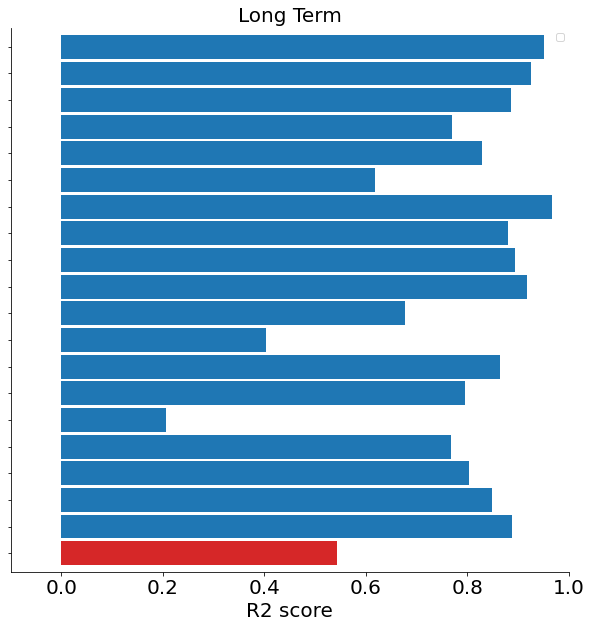

In [170]:


fs=20 # font size
# for idx,clm in enumerate(column_list):


idx=2 #manually change it [0,1,2]
clm=column_list[idx] 
df_r2 = mydf[clm]

ax=df_r2.plot.barh(figsize=(10,10),width=0.9,fontsize=fs, color=mydf['color'])

ax.set_xlabel('R2 score',fontsize=fs)

ax.legend('')
ax.set_title(clm, fontsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if idx!=0:
  plt.tick_params(
      axis='y',          # changes apply to the y-axis
      labelleft=False) # labels along the bottom edge are off
fig = ax.get_figure()
plt.xlim([-.1,1])
# fig.show()
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/figures/'+data_type+'_'+clm+'_v2.png',bbox_inches='tight')

# Now load all stocks and show deviation of R2 score

In [192]:
df_t=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/figures/twitter.csv', index_col=0)
df_r=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/figures/reddit.csv', index_col=0)
df_y=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/figures/yahoo.csv', index_col=0)

title_list=['Yahoo data analysis', 'Twitter data analysis', 'Reddit data analysis']


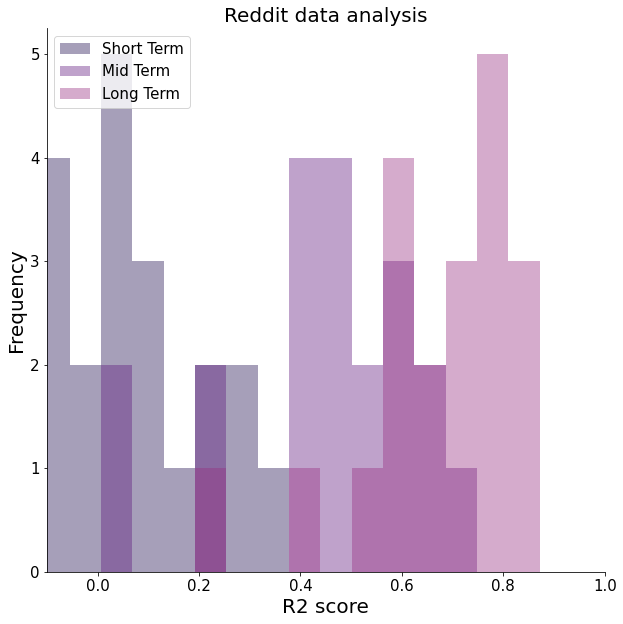

In [218]:
data_type_list=['yahoo','twitter','reddit']
idx=2;

title_list=['Yahoo data analysis', 'Twitter data analysis', 'Reddit data analysis']
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/figures/'+data_type_list[idx]+'.csv', index_col=0)


ax=df.plot.hist(bins=16, figsize=(10,10),alpha=0.4, fontsize=15, color=sns.color_palette('magma')) #hls, rocket, magma, flare
ax.set_xlabel('R2 score',fontsize=fs)
ax.set_ylabel('Frequency',fontsize=fs)
plt.legend(loc=2, prop={'size': 15})
ax.set_title(title_list[idx], fontsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
plt.xlim([-.1,1])
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/figures/histogram_'+data_type_list[idx]+'.png',bbox_inches='tight')